In [1]:
import os
import glob
import pywt
import pywt.data
import numpy as np
import pandas as pd
import seaborn as sns
from random import randint
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
actvs = ('brushteeth', 'cook', 'drink', 'getintobed', 'nothing', 'sitdown_chair', 'sitdown_sofa',
         'sleeping', 'standup_chair', 'standup_sofa', 'walk', 'washingdishes')

actvs_cur = ('nothing', 'walk', 'brushteeth')

path_train = os.getcwd() + "\PCA_train_csv"
path_test = os.getcwd() + "\PCA_test_csv"

pca_train = []
pca_test = []


for act in actvs_cur:
    lst_train = glob.glob(f'PCA_train_csv/{act}*')
    lst_test = glob.glob(f'PCA_test_csv/{act}*')

    for f in lst_train:
        fname = os.path.basename(f)
        fpath = os.path.join(path_train, fname)
        pca_train.append(pd.read_csv(fpath))

    for f in lst_test:
        fname = os.path.basename(f)
        fpath = os.path.join(path_test, fname)
        pca_test.append(pd.read_csv(fpath))

In [3]:
# 100Hz
N = 7
L = 15
scales = [2 ** (n + (l / L)) for n in range(N) for l in range(L)]

matr_train = []
matr_test = []


for df in pca_train:
    coef, freqs = pywt.cwt(df['0'], scales=scales, wavelet='mexh')   # wavelet='morl'
    m = coef
    coef, freqs = pywt.cwt(df['1'], scales=scales, wavelet='mexh')   # wavelet='morl'
    m = np.add(m, coef)
    coef, freqs = pywt.cwt(df['2'], scales=scales, wavelet='mexh')   # wavelet='morl'
    m = np.add(m, coef)
    matr_train.append(m)


for df in pca_test:
    coef, freqs = pywt.cwt(df['0'], scales=scales, wavelet='mexh')   # wavelet='morl'
    m = coef
    coef, freqs = pywt.cwt(df['1'], scales=scales, wavelet='mexh')   # wavelet='morl'
    m = np.add(m, coef)
    coef, freqs = pywt.cwt(df['2'], scales=scales, wavelet='mexh')   # wavelet='morl'
    m = np.add(m, coef)
    matr_test.append(m)

In [4]:
l_train = [m.shape[1] for m in matr_train]
l_test = [m.shape[1] for m in matr_test]

ptrn = matr_train[0]
med = 300


for i, m in enumerate(matr_train):
    c = m.shape[1]
    if c < med:
        d = med - c
        matr_train[i] = np.concatenate((m, ptrn[:, :d]), axis=1)
    if c > med:
        matr_train[i] = m[:, :med]


for i, m in enumerate(matr_test):
    c = m.shape[1]
    if c < med:
        d = med - c
        matr_test[i] = np.concatenate((m, ptrn[:, :d]), axis=1)
    if c > med:
        matr_test[i] = m[:, :med]

In [5]:
vect_train = [m.flatten() for m in matr_train]
vect_test = [m.flatten() for m in matr_test]

df_train = pd.DataFrame(vect_train)
df_test = pd.DataFrame(vect_test)

In [6]:
y_train = [i for i in (0, 1, 2) for _ in range(30)]
y_test = [i for i in (0, 1, 2) for _ in range(10)]

In [17]:
# param = {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
model = RandomForestClassifier()
res = model.fit(df_train, y_train)
pred = res.predict(df_test)
res.score(df_test, y_test)

0.5

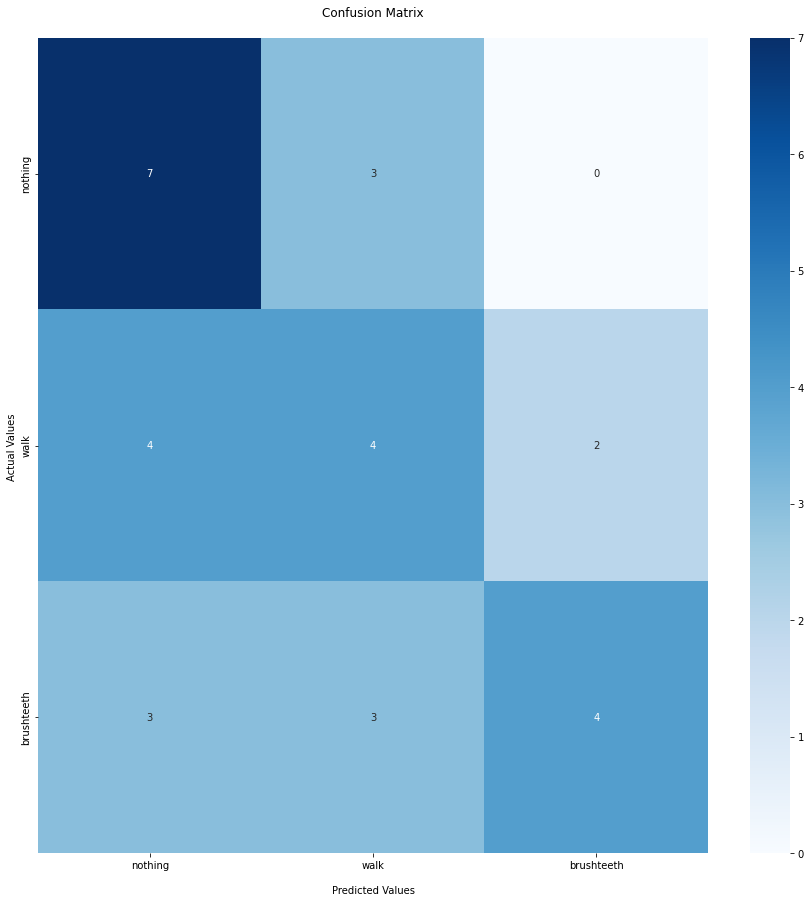

In [19]:
plt.figure(figsize = (15, 15))
cf_matrix = confusion_matrix(y_test, pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(actvs_cur)
ax.yaxis.set_ticklabels(actvs_cur, rotation=90, va="center")
plt.show()